In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle

## Configuration

### Plotting styling

In [4]:
colors = {}
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstc'] = 'black'
colors['AutoEncoderTelescopeMSE'] = 'tab:blue'
colors['AutoEncoderStride'] = 'tab:orange'
colors['AutoEncoderQKerasTTbar'] = 'tab:red'
colors['AutoEncoderQKerasEle'] = 'tab:green'


styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstc'] = '--'
styles['AutoEncoderTelescopeMSE'] = '-'
styles['AutoEncoderStride'] = '-'
styles['AutoEncoderQKerasTTbar'] = '--'
styles['AutoEncoderQKerasEle'] = '--'

markers = {}
markers['Threshold0'] = 'o'
markers['Threshold'] = 'o'
markers['Mixedbcstc'] = 'o'
markers['AutoEncoderTelescopeMSE'] = 'o'
markers['AutoEncoderStride'] = 'o'
markers['AutoEncoderQKerasTTbar'] = 'o'
markers['AutoEncoderQKerasEle'] = 'o'



legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstc'] = 'BC+STC'
legends['AutoEncoderTelescopeMSE'] = 'AE Telescope MSE'
legends['AutoEncoderStride'] = 'AE Stride'
legends['AutoEncoderQKerasTTbar'] = 'AE QKeras ttbar'
legends['AutoEncoderQKerasEle'] = 'AE QKeras Ele'

ref_name = 'Threshold0'
plotted_algo = ['Threshold0',
                'Threshold',
                'Mixedbcstc',
                'AutoEncoderTelescopeMSE', 
                'AutoEncoderStride',
                'AutoEncoderQKerasTTbar',
                'AutoEncoderQKerasEle',
               ]

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [5]:
version = '210611'
fig_dir = 'img/electron_photon_calib_autoencoder_{}'.format(version)
algo_files = {}
# Read  first set
directory = '/Users/cmantill/ECON/ASIC/ECONAutoencoderStudy/notebooks/data/3_22_1/electron_photon_signaldriven/v_1_2021-06-11'
fes = ['Threshold0', 'Threshold', 'Mixedbcstc',
       'AutoEncoderTelescopeMSE', 'AutoEncoderStride',
       'AutoEncoderQKerasTTbar', 'AutoEncoderQKerasEle',]

for fe in fes:
    algo_files[fe] = (glob(directory+'/electrons/*.hdf5'), glob(directory+'/photons/*.hdf5'))

## Loading and preprocessing dataframes

In [6]:
algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())

Selection cuts (in addition to those already applied before):
- Gen particle $p_T > 5 GeV$
- Cluster $p_T > 3 GeV$
- Extrapolated gen particle eta between 1.6 and 2.9

Additionally label electrons and positrons as `0` and photons as `1`.

In [7]:
ptcut=5
clptcut=3
etamin=1.6
etamax=2.9
algo_cut={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = algo_cut[name]['cl3d_pt']>clptcut
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_cut[name]['genpart_pid'].replace([22],0, inplace=True)

In [8]:
for name,df in algo_cut.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

## Energy corrections
### Layer weights
On 0PU photon clusters:
- Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
- Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [9]:
layer_coeffs = {}
for name,df in algo_cut.items():
    print(name)
    # select layers [2,14]
    select = df.query('genpart_pid==0')
    layers = np.array(select['cl3d_layer_pt'].tolist())[:,2:15]
    regression = lsq_linear(layers, select['genpart_pt'],
                              bounds = (0.,2.0),
                              method='bvls',
                              lsmr_tol='auto',
                              verbose=1)
    layer_coeffs[name] = regression.x
    print(regression.x)

Threshold0
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 3.5499e+05, final cost 2.1625e+05, first-order optimality 4.52e-09.
[2.         0.73860446 1.19535509 0.96724476 0.95240618 1.16431118
 1.07315948 1.01801906 0.87101609 0.71409254 1.18870243 2.
 2.        ]
Threshold
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 3.2776e+05, final cost 2.2606e+05, first-order optimality 5.17e-08.
[2.         0.79709936 1.19931171 0.97933342 0.96207754 1.16870804
 1.08054395 1.02128725 0.89496268 0.72786837 1.1516143  2.
 2.        ]
Mixedbcstc
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 3.7623e+05, final cost 2.5728e+05, first-order optimality 1.66e-09.
[2.         0.81359271 1.19002913 0.95892777 1.00470734 1.4943739
 0.9833105  1.18204017 1.08026033 0.81839132 1.55554147 2.
 2.        ]
AutoEncoderTelescopeMSE
The relative change of the cos

Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [10]:
# Apply calibration
for name,df in algo_cut.items():
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_coeffs[name])
    df['cl3d_over_gen_pt'] = df['cl3d_pt']/df['genpart_pt']
    df['calib_over_gen_pt'] = df['cl3d_pt_calib']/df['genpart_pt']

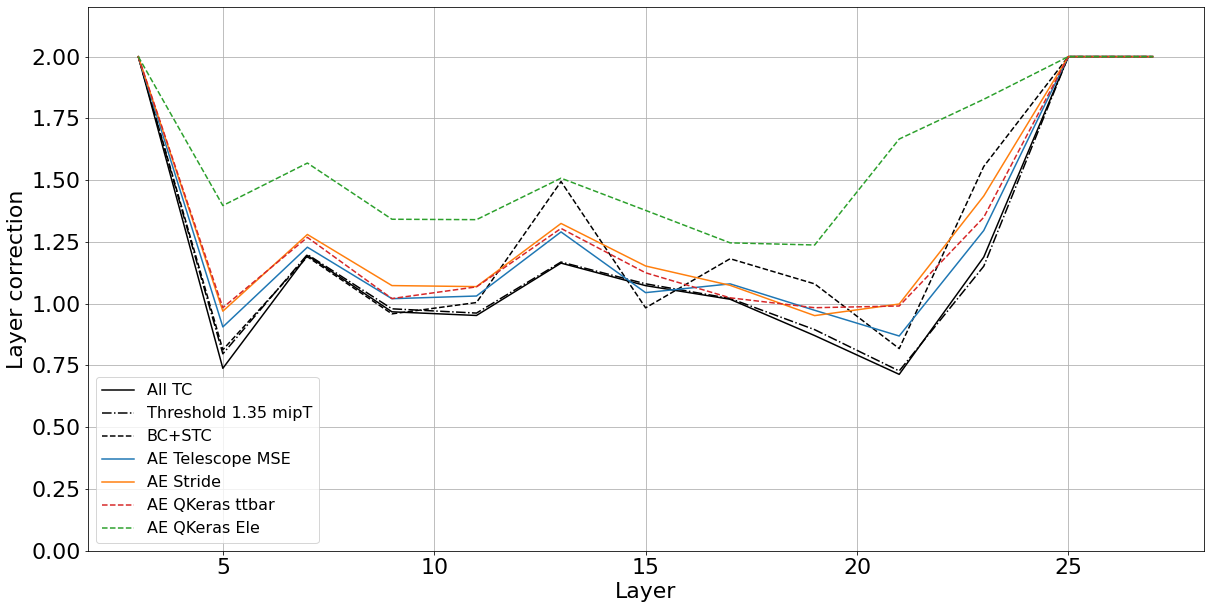

In [11]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for name,weights in layer_coeffs.items():
    plt.plot(range(3, 29, 2), weights, label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.show()

Check impact of layer corrections on the energy ratio distributions

Raw mean=0.9608724117279053, rms=0.03253152593970299, rms/mean=0.033856239169836044
Calib mean=0.9986501678456767, rms=0.03997560814062294, rms/mean=0.040029641437761665


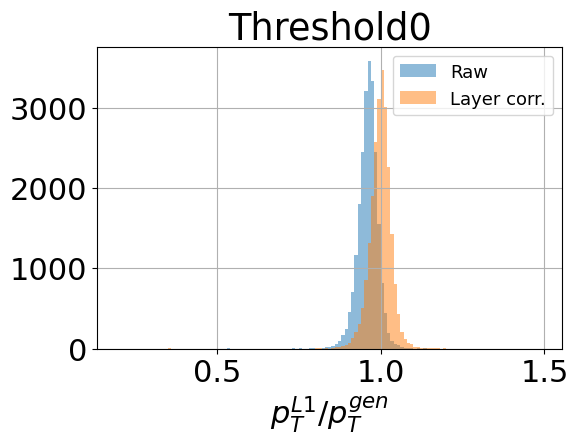

Raw mean=0.9407053589820862, rms=0.03906107321381569, rms/mean=0.041523173451423645
Calib mean=0.9874221956337735, rms=0.04527619175093577, rms/mean=0.04585292081861235


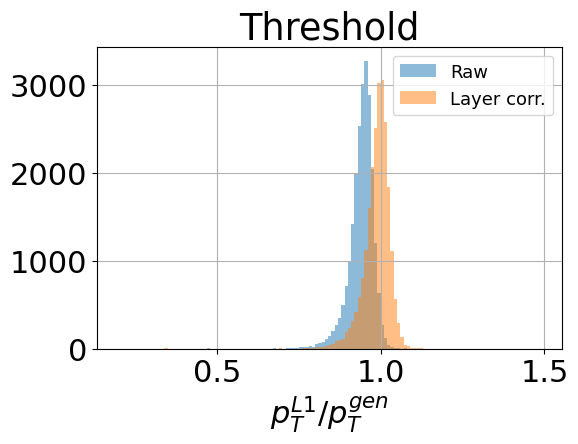

Raw mean=0.8871003985404968, rms=0.03542423993349075, rms/mean=0.03993261605501175
Calib mean=1.0017013383549964, rms=0.043235691796553545, rms/mean=0.04316225819120459


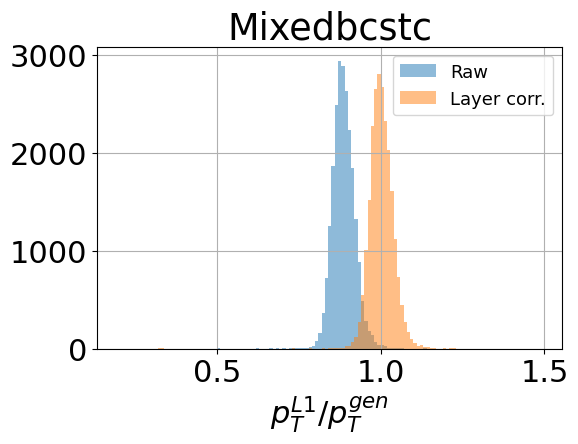

Raw mean=0.898751974105835, rms=0.035037823021411896, rms/mean=0.03898497298359871
Calib mean=0.996291471815274, rms=0.04404887039457079, rms/mean=0.04421283493906897


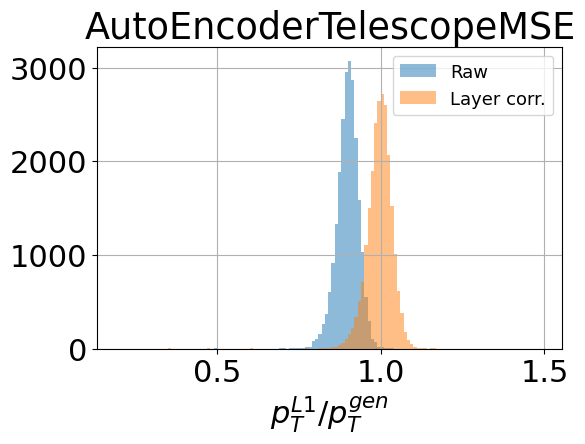

Raw mean=0.8614853620529175, rms=0.035337209701538086, rms/mean=0.041018933057785034
Calib mean=0.9962489562357224, rms=0.045913099317043744, rms/mean=0.04608596980670788


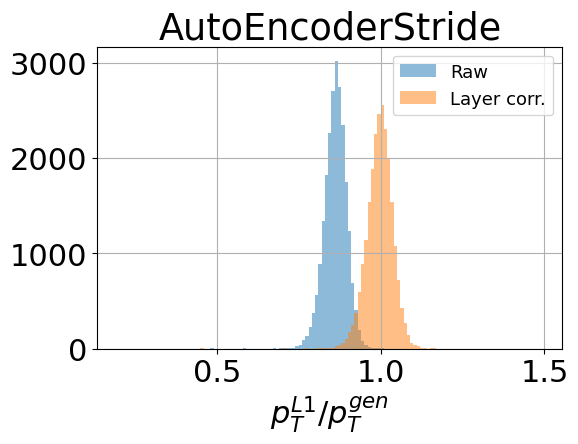

Raw mean=0.8763746619224548, rms=0.040020450949668884, rms/mean=0.0456659160554409
Calib mean=0.9954543954234272, rms=0.0500051443620798, rms/mean=0.05023348592560042


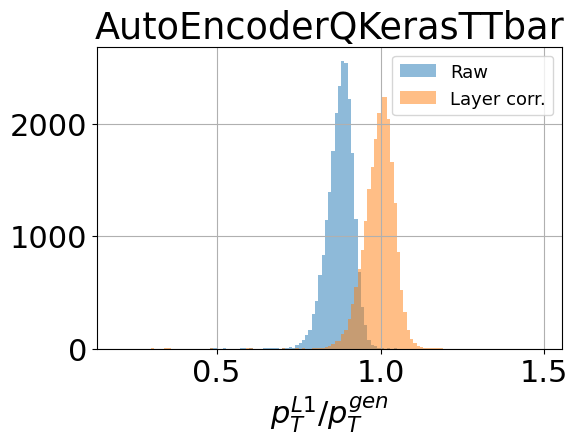

Raw mean=0.703599750995636, rms=0.04491127282381058, rms/mean=0.06383071094751358
Calib mean=0.9958099809485312, rms=0.06709896233586389, rms/mean=0.06738129122982944


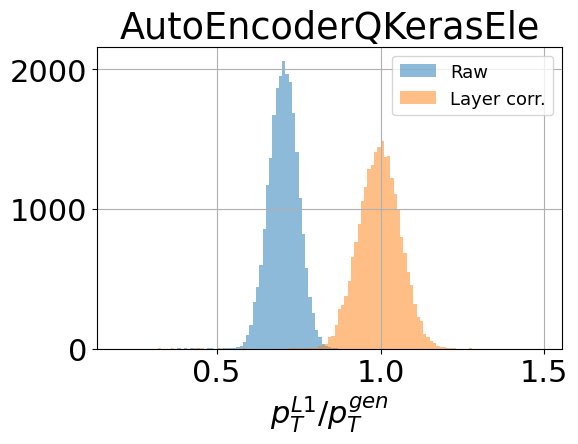

In [12]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==0')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.')
    plt.title(name)
    plt.legend(fontsize=13)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.grid()
    plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

In [13]:
corrs = {}
corrs['eta'] = {}
for name,df in algo_cut.items():
    print('  '+name)
    select = df.query('genpart_pid==1')
    X = select[['cl3d_abseta']]
    y = select['genpart_pt']-select['cl3d_pt_calib']
    corrs['eta'][name] = LinearRegression().fit(X, y)

  Threshold0
  Threshold
  Mixedbcstc
  AutoEncoderTelescopeMSE
  AutoEncoderStride
  AutoEncoderQKerasTTbar
  AutoEncoderQKerasEle


Print correction value at eta=1.5 and eta=3

In [14]:
for name,df in algo_cut.items():
    corr = corrs['eta'][name]
    print(name)
    print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
    print('  eta=3:', corr.intercept_+corr.coef_*3)

Threshold0
  eta=1.5: [4.0258064]
  eta=3: [-9.606129]
Threshold
  eta=1.5: [3.733715]
  eta=3: [-9.228403]
Mixedbcstc
  eta=1.5: [4.723342]
  eta=3: [-3.5603952]
AutoEncoderTelescopeMSE
  eta=1.5: [4.744129]
  eta=3: [-16.939957]
AutoEncoderStride
  eta=1.5: [4.458006]
  eta=3: [-15.61804]
AutoEncoderQKerasTTbar
  eta=1.5: [4.2907276]
  eta=3: [-17.157923]
AutoEncoderQKerasEle
  eta=1.5: [5.085333]
  eta=3: [-16.678875]


In [15]:
for name,df in algo_cut.items():
    df['cl3d_corr_eta'] = corrs['eta'][name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr_eta'] =  df['cl3d_corr_eta']+df.cl3d_pt_calib
    df['corr_eta_over_gen_pt'] = df['cl3d_pt_corr_eta']/df['genpart_pt']    

Raw mean=0.9984573125839233, rms=0.12111703306436539, rms/mean=0.12130416929721832
Calib mean=1.0398872665869088, rms=0.10855158928095815, rms/mean=0.1043878435373513
Corr eta mean=0.9968409140031037, rms=0.06675012022447041, rms/mean=0.06696165786014535


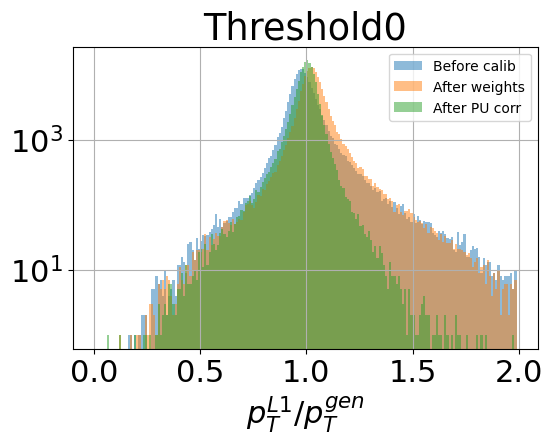

Raw mean=0.9700270295143127, rms=0.09863631427288055, rms/mean=0.1016840860247612
Calib mean=1.0314721128060917, rms=0.09909055209784794, rms/mean=0.0960671169560511
Corr eta mean=0.9890476402956774, rms=0.07268040170592496, rms/mean=0.07348523847061304


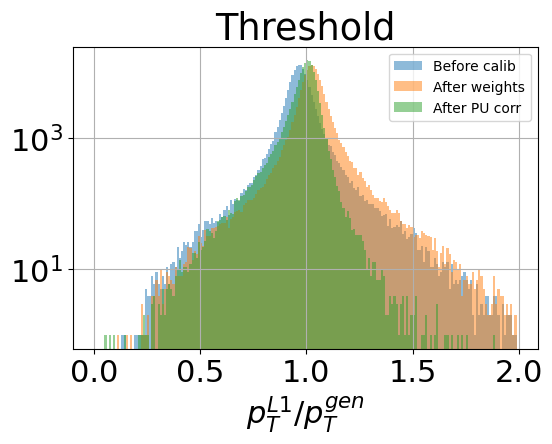

Raw mean=0.8996961116790771, rms=0.08620188385248184, rms/mean=0.09581222385168076
Calib mean=0.9924715807040839, rms=0.07886373292966088, rms/mean=0.07946195585138367
Corr eta mean=1.0022100622757995, rms=0.06737036039756407, rms/mean=0.06722179604202011


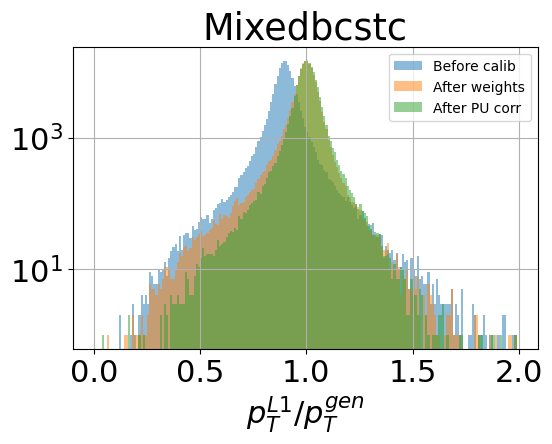

Raw mean=0.9681247472763062, rms=0.1364581286907196, rms/mean=0.1409509778022766
Calib mean=1.0794491751428479, rms=0.1365344926706822, rms/mean=0.12648533697995928
Corr eta mean=0.9848103805922128, rms=0.0874978815779539, rms/mean=0.08884744038272353


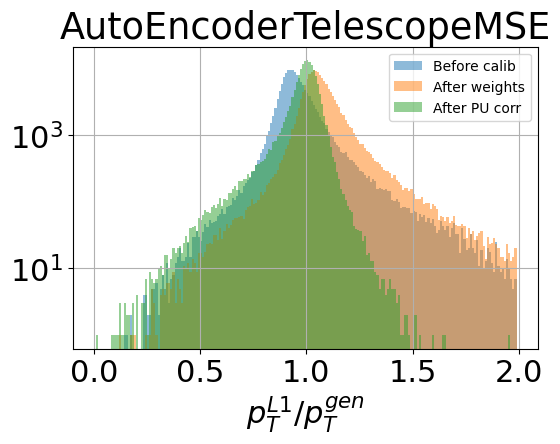

Raw mean=0.924496591091156, rms=0.12758447229862213, rms/mean=0.13800425827503204
Calib mean=1.073227949208178, rms=0.1315449805047793, rms/mean=0.12256946960972505
Corr eta mean=0.9866676638511028, rms=0.08426254504121755, rms/mean=0.08540114177080556


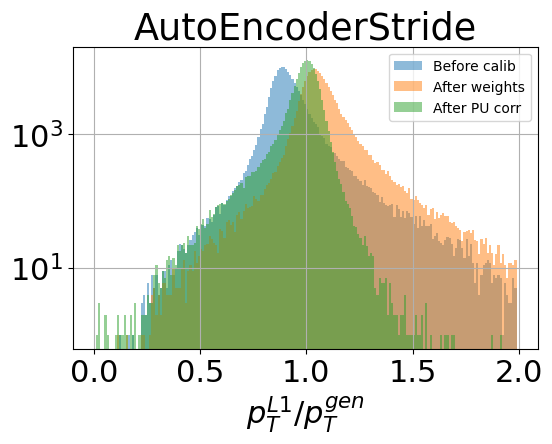

Raw mean=0.9458882212638855, rms=0.13178786635398865, rms/mean=0.13932710886001587
Calib mean=1.0820156649409738, rms=0.13508079845785043, rms/mean=0.12484181406488173
Corr eta mean=0.9821892025386952, rms=0.09509527384532626, rms/mean=0.0968197100920378


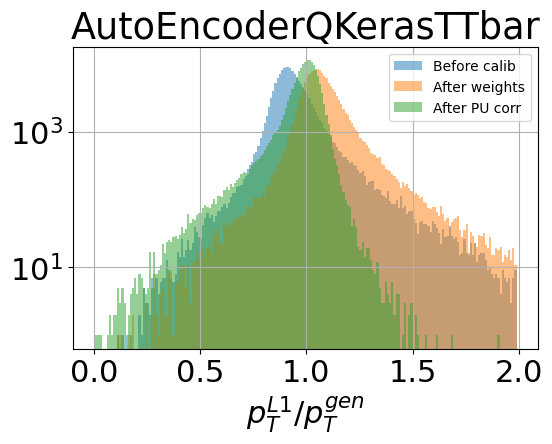

Raw mean=0.7618560194969177, rms=0.12206494063138962, rms/mean=0.16022048890590668
Calib mean=1.0798375495906318, rms=0.1519938199436106, rms/mean=0.14075619059666125
Corr eta mean=0.9899681133415973, rms=0.0930198527975454, rms/mean=0.09396247368368327


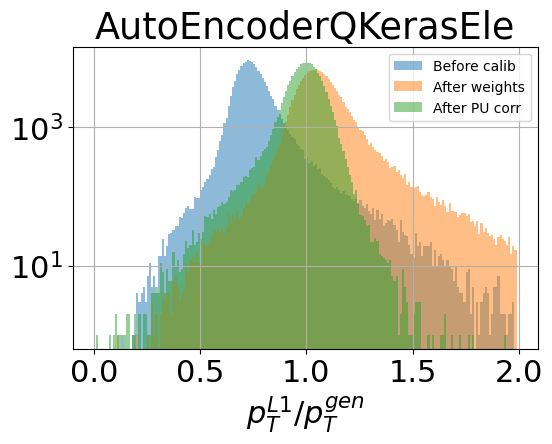

In [16]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        select['corr_eta_over_gen_pt'].mean(),
        select['corr_eta_over_gen_pt'].std(),
        select['corr_eta_over_gen_pt'].std()/select['corr_eta_over_gen_pt'].mean()
    ))
    #plt.figure(figsize=(15,10))
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='Before calib')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After weights')
    plt.hist(select['corr_eta_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After PU corr')
    plt.grid()
    plt.legend(loc = 'upper right', fontsize=10)
    plt.yscale('log')
    plt.title(name)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.show()

## Final plots
For electrons with 200PU, looking at $p_T > 10\,GeV$
First bin in eta and pT

In [17]:
binetasize = 0.1
binptsize = 5
for name,df in algo_cut.items():
    df['genpart_abseta'] = np.abs(df.genpart_exeta)
    df['genpart_bineta'] = ((df.genpart_abseta - etamin)/binetasize).astype('int32')
    df['genpart_binpt'] = (df.genpart_pt/binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [18]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [19]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {} 
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    #print(etarmss[name])

Mean vs eta


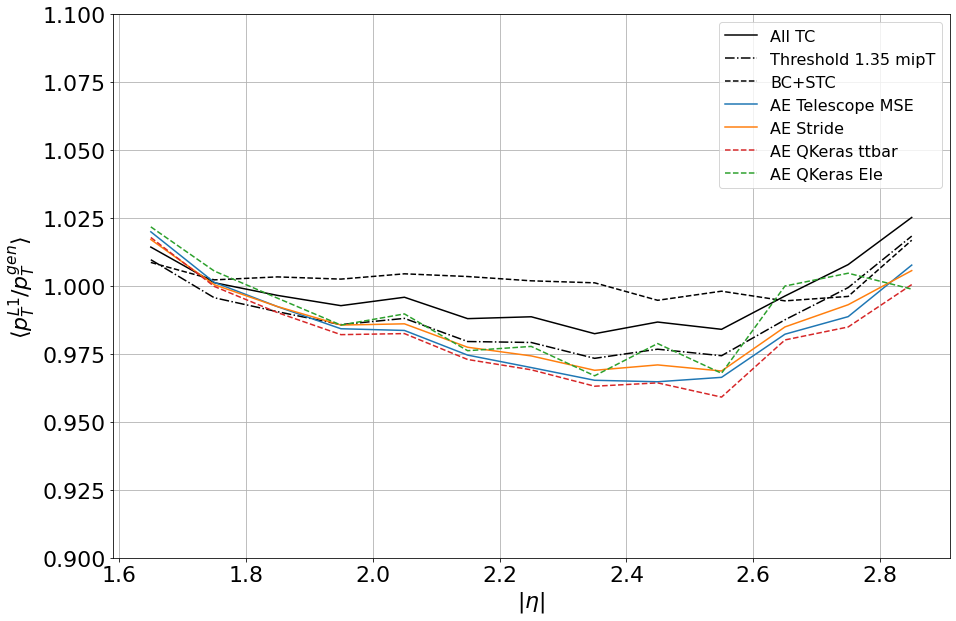

RMS vs eta


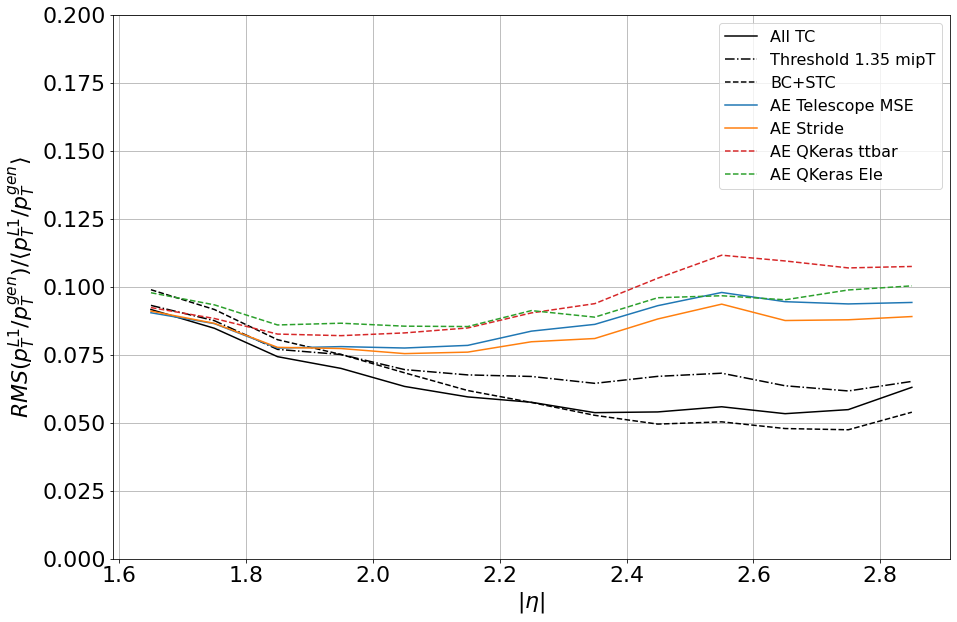

Eff RMS vs eta


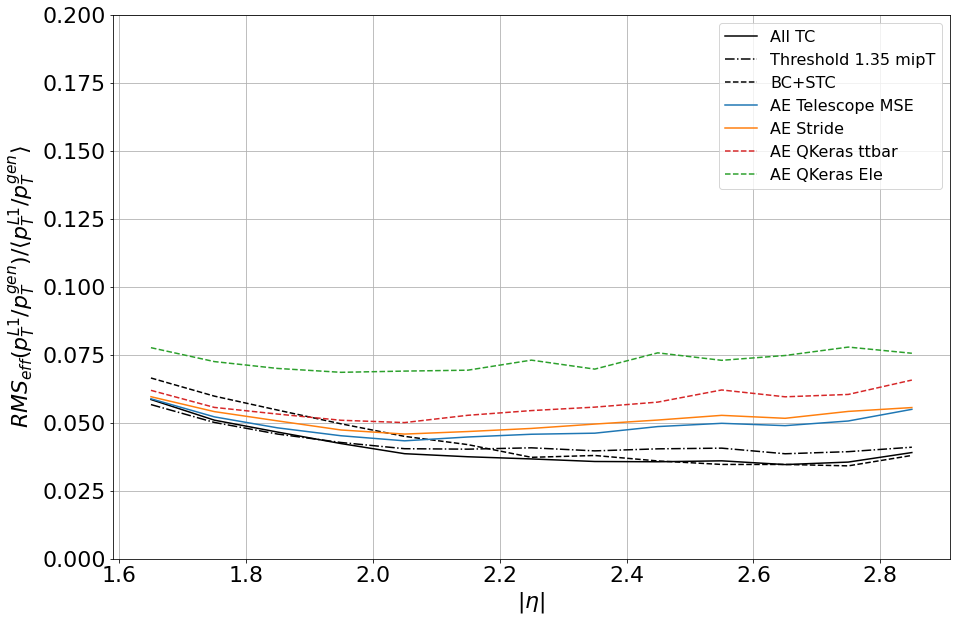

Mean vs pt


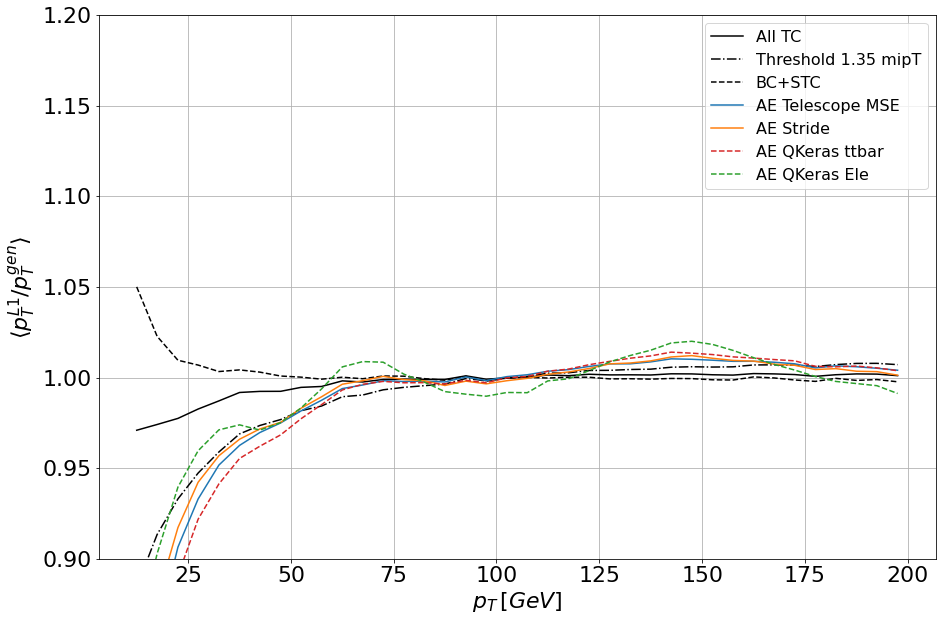

RMS vs pt


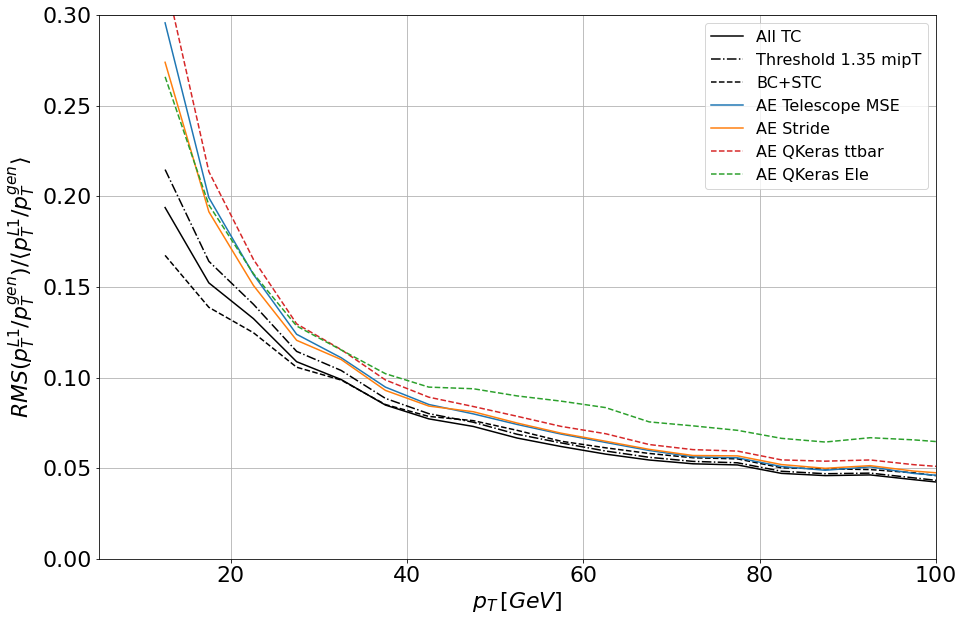

Eff RMS vs pt


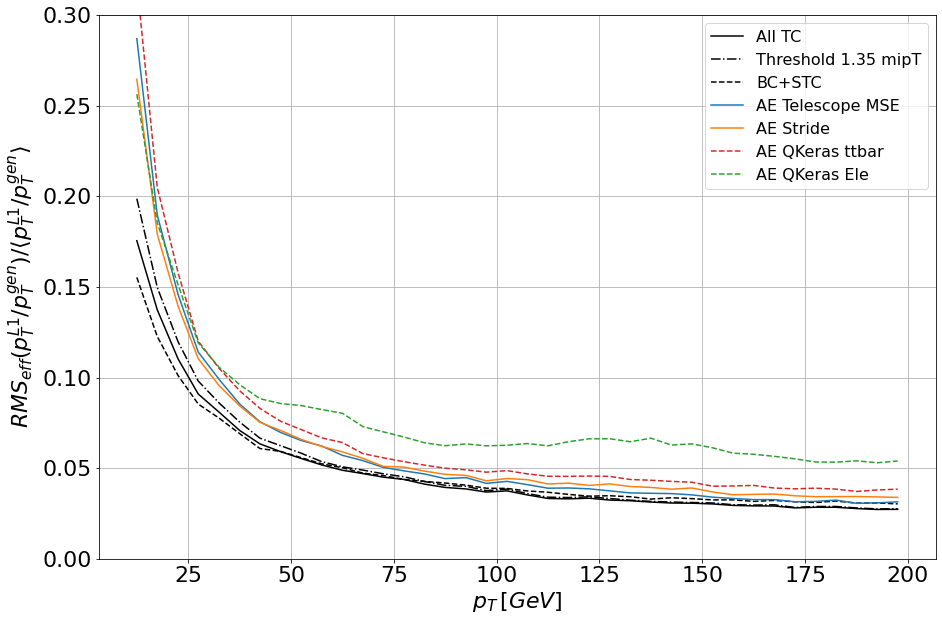

In [20]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.3)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.3)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

## Storing layer weights and eta corrections for external use

In [21]:
with open('data/layer_weights_photons_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(layer_coeffs, f)
with open('data/lineareta_electrons_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(corrs['eta'], f)